# $\textbf{Antimony quoct noise spectroscopy}$

A qudit spectator is surrounded by XYZ type noises and affected by a sequence of spectroscopy reference pulse sequence.
The effective Hamiltonian of such qudit in Weyl basis is as follows:
\begin{equation}
H(t) =
\sum_{\substack{a,b,a',b'  \in S}}\beta_{ab}(t) y^{a b}_{a'b'}(t) Z^{a'}  X^{b^\prime},
\end{equation}
where $\beta_{ab}(t)$ are the unknown noise functions, $y^{a b}_{a'b'}(t)$ are the switching functions containing information about the known pulse sequence, and Z/X are the generalized Pauli operators in d-dimension. 

Here we simulate the generalized Weyl basis quantum noise spectroscopy for the Antimony quoct system with d=8.


In [1]:
import numpy as np
import matplotlib as m
import matplotlib.pyplot as plt
import time


d=8            # 8 dimensional qudit (Antimony quoct system)
T = 1          # Alvarez-Suter referece pulse duration
M = 800         # Alvarez-Suter repetitions for each of three rounds
W = 55         # Maximum sensible frequency
hbar=1         # reduced Planck constant assumed 1
gn = 1         # nuclear gyromagnetic ratio, assumed 1 and dimentionless, since the value has no effect on simulation result
tB0= 1         # static magnetic field, assumed 1 and dimensionless, , since the value has no effect on simulation result
varsnum = 3    # number of unknonw noise polyspectra


xi = np.exp(2*np.pi*1j/d)         
def wr(r): return  2*np.pi*r/T           
N = int(W/wr(1))                  # The number of Alvarez-Suter expreriments in each of the three rounds
                                  

def delta(s1, s2):
    return np.array(s1 == s2, dtype=int)
def deltam(s1, s2, m):
    return np.array(np.remainder(s1, m) == np.remainder(s2, m), dtype=int)    
def fd(var):   return np.remainder(var, d)  

## Switching Function

In [2]:
def y(i,j,a,b,m,n):
    
    i = np.fmod(i,d)
    j = np.fmod(j,d)
    a = np.fmod(a,d)
    b = np.fmod(b,d)
    m = np.fmod(m,d)   
    n = np.fmod(n,d)  


    def fdt(i,j,b,a):
        return  1/d * (  delta(np.remainder(i-j,d),np.remainder(b,d)) * xi**(a*i)   +\
                         delta(np.remainder(j-i,d),np.remainder(b,d)) * xi**(a*j)  ) 
    def fijb(i,j,b,m,a):
        return  1/d * (  xi**((a-m)*(i+b))   +   xi**(-m*i+a*j)   )
    def f0val(a,b,m,i,j):
        return  1/d * (  d * deltam(a,m,d) * xi**(-m*i)   -  ( xi**((a-m)*i) + xi**((a-m)*j) ) * ( xi**((a-m)*b) + 1 )  ) 
    def f12valone(m,i,j,b,a):
        return xi**(-m*i) * fdt(i,j,b,a)
    def f12valtwo(m,i,j,b,a):
        return xi**(-m*j) * fdt(i,j,b,a)



    f0 =  f0val(a,b,m,i,j)
    f1 =  f12valone(m,i,j,b,a)
    f2 =  f12valtwo(m,i,j,b,a)
    f3 =  fijb(i,j,b,m,a)
    f4 =  fijb(j,i,b,m,a)

    
    resultvec = np.zeros((6,) + np.broadcast(i, j, a, b, m, n).shape, dtype=complex) 
    resultvec[0, ...] = -(f1+f2) 
    resultvec[1, ...] = f0
    resultvec[2, ...] = f1
    resultvec[3, ...] = f2
    resultvec[4, ...] = f3 
    resultvec[5, ...] = f4 



    fcond = np.zeros((6,) + np.broadcast(i, j, a, b, m, n).shape, dtype=complex)  # n.shape)
    fcond[0, ...] = (n == 0)
    fcond[1, ...] = (n == b)
    fcond[2, ...] = (n==np.remainder(i-j,d))
    fcond[3, ...] = (n==np.remainder(j-i,d))
    fcond[4, ...] = (n==np.remainder(i-j+b,d))
    fcond[5, ...] = (n==np.remainder(j-i+b,d))
    

    result = np.sum(resultvec * fcond, axis=0) 

    return result        


i = j = a = b = m = n =  np.arange(d) 
I0, J0, A0, B0, M0, N0 = np.meshgrid(i, j, a, b, m, n, sparse=True, indexing='ij')
yvec = y(I0, J0, A0, B0, M0, N0)
del i,j,a,b,m,n,I0, J0, A0, B0, M0, N0

## Random pulse sequences 

In [ ]:
import random
count = 0
while count ==0:
    
    IJ = np.zeros([d])
    IJ = random.sample(range(d),d)       
   
    def f(a,b,a1,b1,w,r,T,pm):
        result =   -(1j)/((-1)**(pm)*w) * sum(y(IJ[fd(i)],IJ[fd(i+1)],a,b,a1,b1) \
                                              *(exp( (1j)* ((-1)**(pm)*w) *(i+1)*T/(d* (r+1) ) )  -   \
                                                exp( (1j)* ((-1)**(pm)*w) * i   *T/(d* (r+1) ) )      )
                                          for i in range(d))
        return result  

    for a in range(d):
         for a1 in range(d):
            for b1 in range(d):
                 for k in range(N):
                        for r in range(N):
                                if  abs(f(a,0,a1,b1,(k+1)*wr(1),r,T, 0)) > 0.001 or \
                                    abs(f(a,0,a1,b1,(k+1)*wr(1),r,T, 1)) > 0.001:
                                            count = count + 1
                                            print(a,a1,b1,r,k, f(a,0,a1,b1,(k+1)*wr(1),r,T, 0), f(a,0,a1,b1,(k+1)*wr(1),r,T, 1))
del count,a,a1,b1,k,r
print(IJ)
# [1, 6, 7, 5, 4, 3, 0, 2] 
# [7, 6, 2, 0, 1, 5, 4, 3]
#[7, 2, 0, 6, 4, 3, 1, 5]

## Chosen pulse sequequence

In [3]:
IJ = np.array([0, 4, 5, 3, 6, 1, 7, 2])

## Filter function

The following f-function, when vectorized, corresponds to fVec found by einsum

def f(a,b,a1,b1,k,r,pm):  

         w = (-1)**(pm) *  (k+1)*wr(1)         
         return     sum( -(1j)/w  *  yvec0[IJ[fd(i)]][IJ[fd(i+1)]][a][b][a1][b1] *\
                                      (np.exp( (1j)* w *fd(i+1)*T/(d* (r+1) ) )  -   \
                                       np.exp( (1j)* w * fd(i)   *T/(d* (r+1) ) )      )
                        for i in range(d))   
                        
pm corresponds to negative \omega (w)
 
#### Variables' indices in einsum
   (i,a,b,a1,b1,k,r,pm) => (i,a,b,c, d, k,r,p)

In [4]:
def expterm(i,k,r,pm): 
    w = (-1)**(pm) * (k+1)*wr(1)
    return       np.exp(   (1j)* w * fd(i+1)* T/(d* (r+1) ) )  -    np.exp( (1j)* w * fd(i)   *T/(d* (r+1) ) ) 

i =  np.arange(d)
k = np.arange(N)
r =  np.arange(N)
pm = np.arange(2)
I0, K, R, PM = np.meshgrid(i,k, r, pm, sparse=True, indexing='ij')
exptermVec = expterm(I0, K, R, PM) 
del i,k,r,pm,I0,K,R,PM
##################################################################
def wterm(k,pm): 
    w = (-1)**(pm) * (k+1)*wr(1)
    return      -(1j)/w 

k =  np.arange(N)
pm = np.arange(2)
K, PM = np.meshgrid(k, pm, sparse=True, indexing='ij')
wtermVec = wterm(K, PM) 
del k,pm,K,PM
##################################################################
i = np.arange(d)
yvec01 = yvec[IJ[fd(i)],IJ[fd(i+1)]]
del i
###################################################################
fvec = np.einsum('kp,iabcd,ikrp -> abcdkrp', wtermVec,yvec01,exptermVec)

The function $\tilde{\beta}_{iab}^{pqq'}$ coded as "b1f" includes the intrinsic parameters of the Antimony quoct Hamiltonian

$\sum\limits_{pqq'\in S} \tilde{\beta}^{pqq'}_{iab}$ =  b1f(iab) $→$ b1Vec$[i][a][b]$


In [5]:
Itot = (d-1)/2
def Iz(p):
    return        hbar  * (Itot-p)
def Ix(p,q):
    return        hbar/2* (deltam(p,q+1,d) + deltam(p+1,q,d) )*  np.sqrt( (Itot+1)*(p+q+1)-(p+1)*(q+1)) 
def Iy(p,q):
    return     1j*hbar/2* (deltam(p,q+1,d) - deltam(p+1,q,d) )*  np.sqrt( (Itot+1)*(p+q+1)-(p+1)*(q+1)) 

In [6]:
def tbeta(i,p,q,q1,a,b):
    
    conditions = [i == 0, i == 1, i == 2]
    
    choices = xi**(-a*p)*  deltam(b,0,d)*    1/(2*d**3) *  Iz(p) ,\
              xi**(-a*p)*  deltam(p-q,b,d)*  1/d *         Ix(p,q)*Ix(q,q1) ,\
              xi**(-a*p)*  deltam(b,0,d)*    1/(d**3) *    Iz(p)     * gn * tB0 
    
    default = np.nan
    
    result = np.select(conditions, choices, default=default)
    
    return result

In [7]:
def b1f(i,a,b):
      return  sum(tbeta(i,p,q,q1,a,b)\
                 for p in range(d)  for q in range(d)  for q1 in range(d)  )

a = b =  np.arange(d)
i = np.arange(3)
I0, A, B = np.meshgrid(i, a, b, sparse=True, indexing='ij')
b1Vec0 = np.array(b1f(I0, A, B))
b1Vec =  b1Vec0.astype(np.complex128)
del i, a, b, I0, A, B

## Fixed indices for observable and initial density matrix

We assume the measurable operator $\hat{O}=\{O_{mn}\}_{m,n \in {0,...,d}}$ to possess only one nonzero term $O_{mn}$ for each required round of measrement. We also assume that the initial density matrix of the quoct as $\hat{\rho}=\{\rho_{pq}\}_{p.q \in {0,...,d}}$ would have only 1 nonzero component. 

There are three measurement rounds for the Antiony quoct. This is because the Antimony noise spectroscopy has three unknown real noise polyspectra, the same as Qutrit example.

In [8]:
m11vec = np.zeros([varsnum,4])

# m11vec[m11,:] = [m, n, p, q] 
m11vec[0,:]  =    [1, 7, 0, 4]   
m11vec[1,:]  =    [2, 1, 5, 1]
m11vec[2,:]  =    [2, 6, 1, 0]

## $\lambda$ coefficient

$^{mn}_{ab}\lambda^{a'b'}_{\tilde{a},\tilde{b}}$ is defined, and all its values assigned to a tensor $LL0[m_{11}][\tilde{a}][\tilde{b}][a'][b'][\tilde{a'}][\tilde{b'}]$, where $m_{11}$ or m11vec$[m_{11},:]$ corresponds to a fixed chosen set of (m,n,p,q).

In [9]:
def Lmnpq(m11, a1,b1, ta,tb , ta1,tb1):

    Omn = 1
    return   d*Omn*   (1-xi**(  a1*m11vec[m11,1] -  b1*m11vec[m11,0] )) * \
                      (1-xi**( ta1*m11vec[m11,1] - tb1*m11vec[m11,0] )) * \
                      xi**( \
 - ta1*b1  +  ta*tb  -  ta1*tb1 -  m11vec[m11,0]* m11vec[m11,3]  + (m11vec[m11,0]+m11vec[m11,2])*(m11vec[m11,1]+m11vec[m11,3]) ) 
                      
                      

a1 = b1 = ta = tb =  ta1 = tb1 =  np.arange(d)
m11 = np.arange(3)
M11, A1, B1, TA, TB,  TA1, TB1  = np.meshgrid(m11, a1,b1,  ta,tb,   ta1,tb1,  sparse=True, indexing='ij')
LL0 = Lmnpq(M11,  A1, B1,  TA, TB,  TA1, TB1 )
del m11, a1,b1,  ta,tb,   ta1,tb1, M11, A1, B1, TA, TB,  TA1, TB1

In [10]:
def deltaA(m11,a1,ta1): 
    return  deltam(-m11vec[m11,0]-m11vec[m11,2],a1+ta1,d) 

a1 = ta1 =  np.arange(d)
m11 = np.arange(3)
M11, A1, TA1 = np.meshgrid(m11, a1, ta1, sparse=True, indexing='ij')
deltaVecA = deltaA(M11, A1, TA1)
del m11, a1, ta1, M11, A1, TA1

In [11]:
def deltaB(m11,b1,tb1): 
    return  deltam(-m11vec[m11,1]-m11vec[m11,3],b1+tb1,d) 

b1 = tb1 =  np.arange(d)
m11 = np.arange(3)
M11, B1, TB1 = np.meshgrid( m11, b1, tb1, sparse=True, indexing='ij')
deltaVecB = deltaB(M11, B1, TB1)
del  m11, b1, tb1, M11, B1, TB1

In [12]:
fvec1 =   fvec[:,:,:,:,:,:,0]
fvec2 = np.empty_like(fvec1)
for a in range(d):
    for b in range(d):
        for a1 in range(d):
            for b1 in range(d):
                for k in range(N):
                    for r in range(N):
                            fvec2[a][b][a1][b1][k][r] = np.conj(fvec[-a][-b][-a1][-b1][k][r][0])
del a,b,a1,b1,k,r

## $\Xi_{i,\tilde{i}}(m,n,\omega,t^A_r)$ function 

$\Xi_{i,\tilde{i}}(m,n,\omega,t_r) = 
\sum\limits_{\substack{a,b,\tilde{a},\tilde{b}\\a',b',\tilde{a}',\tilde{b}'
\in S}}
\sum\limits_{\substack{pqq'\in S\\ \tilde{p}\tilde{q}\tilde{q}'\in S}}
\tilde{\beta}^{pqq'}_{iab}
\tilde{\beta}^{\tilde{p}\tilde{q}\tilde{q}'}_{\tilde{i}\tilde{a}\tilde{b}}
(_{\tilde{a}\tilde{b}}^{mn}\lambda^{\tilde{a}'\tilde{b}'}_{a'b'})
F^{ab}_{a'b'}(\omega,t_r)
F^{*-\tilde{a},-\tilde{b}}_{-\tilde{a}',-\tilde{b}'}(\omega,t_r)$

The following Xi function, when vectorized, corresponds to XiVec found by einsum 

def Xi(i,ti,k,r,m11):  

    result = np.sum(b1Vec[i][a][b] * fvec[a][b][a1][b1][k][r][0] *
                    b1Vec[ti][ta][tb] * np.conj(np.conj(fvec[-ta][-tb][-ta1][-tb1][k][r][0])) *
                    LL0[m11][a1][b1][ta][tb][ta1][tb1] *
                    deltaVecB[m11][b1][tb1] * deltaVecA[m11][a1][ta1] *  \        
            for a  in range(d)   for b  in range(d)  for a1  in range(d)   for b1  in range(d)   \
            for ta in range(d)   for tb in range(d)  for ta1 in range(d)   for tb1 in range(d)  )

#### Variables' indices in einsum

(i,ti,   k,      m11,   r,      pm   ,       a,b,    a1,b1,   ta,tb,    ta1,tb1) => (a,b,    c,      e,     f,      g    ,       h,i,    j,k,     l,m,      n,o) 


In [16]:
startime = time.time()
########################### start timing

XiVec = np.einsum(' ahi,   hijkcf, blm,   lmnocf, ejklmno, eko,       ejn      -> abcfe', \
                    b1Vec, fvec1,  b1Vec, fvec2,  LL0,     deltaVecB, deltaVecA)

########################### end timing
endtime = time.time()
minutes = ( endtime - startime ) /60
hours   = ( endtime - startime ) /3600
print(minutes,"minutes or", hours, "hours")
############################

17.446767274538676 minutes or 0.2907794545756446 hours
(1.7853684305127335-2.5530652719375238j)


In [17]:
def C(m11, k, r, i):  
    if   i == 0 :   return       XiVec[0][0][k][r][m11]
    elif i == 1 :   return       XiVec[1][1][k][r][m11]    
    elif i == 2 :   return       XiVec[0][1][k][r][m11] + XiVec[1][0][k][r][m11] 

## Coefficient matrix of QNS

In [21]:
P = lambda s,smax : int(s/smax)         
Q = lambda s,smax : np.remainder(s,smax) 

AMat = np.zeros([varsnum*N,varsnum*N], dtype=complex)      

for n in range(varsnum*N):    # n->r                
    for m in range(varsnum*N):   # m->k
        if      delta( (P(m,varsnum) + 1) / (Q(n,N) + 1) , np.floor( (P(m,varsnum) + 1) / (Q(n,N) + 1) ) )   == 1    : 
                AMat[n][m] =  M * wr( Q(n,N) + 1 ) *   \
                                                C(   P(n,N) , P(m,varsnum),   Q(n,N), Q(m,varsnum) ) 
del n,m, P,Q

## Pseudo experimental data

We use the following Poissonian form for the true noise spectra. This choice simplifies the calculations of the exact expectation values, that are supposed to be approximately found by experimental measurements.

In [31]:
def spectA0(w):
    return  w**2*np.exp(-0.2*w)
def spectA1(w):
    return  w**2*np.exp(-0.22*w)
def spectA2(w):
    return  w**2*np.exp(-0.25*w)

grange = 3
gvec = np.array([0.2,  0.22,  0.25]) # coefficients in Poissonian functions 

spect0  = []
spect1  = []
spect2  = []
w1 = wr(1)*np.arange(1, N+0.05, 0.05)
for i in range(len(w1)):
    spect0.append(spectA0(w1[i]))
    spect1.append(spectA1(w1[i]))
    spect2.append(spectA2(w1[i]))

In [33]:
def phi(h,r):
    return h/(r+1) * T/d 

def Phii(h1,h2,n1,n2,r,gi,j):  
    g = gvec[gi]  
    if   j == 0 : return   - g   +  (1j)*d* ( phi(n1-n2,r) )  +  (1j)*( phi(h1+1,r)-phi(h2+1,r) )
    elif j == 1 : return   - g   +  (1j)*d* ( phi(n1-n2,r) )  +  (1j)*( phi(h1+1,r)-phi(h2  ,r) )
    elif j == 2 : return   - g   +  (1j)*d* ( phi(n1-n2,r) )  +  (1j)*( phi(h1  ,r)-phi(h2+1,r) )
    elif j == 3 : return   - g   +  (1j)*d* ( phi(n1-n2,r) )  +  (1j)*( phi(h1  ,r)-phi(h2  ,r) )


def Lancila(h1,h2,r,gi): 
    
    def fj(q):
        if   q == 0 or q==3:  return 0
        elif q == 1 or q==2:  return 1
    
    initial = (1-delta(r,0))*wr(1) + delta(r,0) * 0.0001

    return    sum( (-1)**(fj(j))  *  1/ Phii(h1,h2,n1,n2,r,gi,j) *\
            ( np.exp(Phii(h1,h2,n1,n2,r,gi,j)* W) - np.exp(Phii(h1,h2,n1,n2,r,gi,j)* initial) )                                                                                                                                            
                  for j in range(4)  for n1 in range(M) for n2 in range(M) )

    
    
h1 = h2 =  np.arange(d)
r = np.arange(N)
gi = np.arange(3)
H1, H2, R, GI = np.meshgrid(h1, h2, r, gi, sparse=True, indexing='ij')

startime = time.time()
########################### start timing
LancilaVec = Lancila(H1, H2, R, GI)    
########################### end timing
endtime = time.time()
minutes = ( endtime - startime ) /60
hours   = ( endtime - startime ) /3600
print(minutes,"minutes or", hours, "hours")
############################

49.79748202164968 minutes or 0.8299580336941613 hours


In [23]:
yvec1 = np.zeros([d,d,d,d,d],dtype = complex)  # these has one dimensional less than yvec                                               
yvec2 = np.zeros([d,d,d,d,d],dtype = complex) 

for  h in range(d):
        for a in range(d):
            for b in range(d):
                for a1 in range(d):
                    for b1 in range(d):
                        
                        yvec1[h][a][b][a1][b1] =         yvec[IJ[fd(h)],IJ[fd(h+1)]][a][b][a1][b1]
                      # corresponding indices in einsum:
                      # yvec1[h1][a][b][a1][b1] = yvec[IJ[fd(h1)],IJ[fd(h1+1)]][a][b][a1][b1]  
                      
                        yvec2[h][a][b][a1][b1] = np.conj(yvec[IJ[fd(h)],IJ[fd(h+1)]][-a][-b][-a1][-b1])
                      # corresponding indices in einsum:
                      # yvec2[h2][ta][tb][ta1][tb1] = np.conj(yvec[IJ[fd(h2)],IJ[fd(h2+1)]][-ta][-tb][-ta1][-tb1])
                                          
del h,a,b,a1,b1

## $\Xi_{i,\tilde{i}}(m,n,\omega,t^B_r)$ function for pseudo experimental values

The following XiAI function, when vectorized, corresponds to XiAIVec found by einsum

def XiAI(i,ti,r,m11,gi):  

     result = np.sum(b1Vec[i][a][b] * yvec[IJ[fd(h1)]][IJ[fd(h1+1)]][a][b][a1][b1] *
                     b1Vec[ti][ta][tb] * np.conj(yvec[IJ[fd(h2)]][IJ[fd(h2+1)]][-ta][-tb][-ta1][-tb1]) *
                     LL0[m11][a1][b1][ta][tb][ta1][tb1] *
                     deltaVecB[m11][b1][tb1] * deltaVecA[m11][a1][ta1] *  \
                     LancilaVec[h1][h2][r][gi]
             for h1 in range(d)   for h2 in range(d)
             for a  in range(d)   for b  in range(d)  for a1  in range(d)   for b1  in range(d)   \
             for ta in range(d)   for tb in range(d)  for ta1 in range(d)   for tb1 in range(d)  )

#### Variables' indices in einsum
(i,ti,   h1,h2,   m11,   r,     gi ,      a,b,    a1,b1,   ta,tb,    ta1,tb1) => (a,b,    c,d,     e,     f,     g  ,      h,i,    j,k,     l,m,      n,o)

In [25]:
startime = time.time()
########################### start timing

XiAIVec = np.einsum('ahi,   chijk, blm,   dlmno, ejklmno, eko,       ejn,       cdfg       -> abfeg', \
                     b1Vec, yvec1, b1Vec, yvec2, LL0,     deltaVecB, deltaVecA, LancilaVec)

########################### end timing
endtime = time.time()
minutes = ( endtime - startime ) /60
hours   = ( endtime - startime ) /3600
print(minutes,"minutes or", hours, "hours")
############################

530.4275701522827 minutes or 8.840459502538046 hours
(-368398.5934605172+11889.033672558427j)


In [27]:
def CI(m11, r, gi):   
    if   gi == 0:   return       XiAIVec[0][0][r][m11][0]
    elif gi == 1:   return       XiAIVec[1][1][r][m11][1]
    elif gi == 2:   return       XiAIVec[0][1][r][m11][2] + XiAIVec[1][0][r][m11][2]

grange = 3
def bPn(m11, r):
    return    sum( CI(m11, r, gi) for gi in range(grange) )

In [28]:
bPnVec = np.zeros([varsnum*N], dtype=complex) 
P = lambda s,smax : int(s/smax)         
Q = lambda s,smax : np.remainder(s,smax)

for n in range(varsnum*N):  
    m11 = P(n,N)
    r1  = int(Q(n,N)) 
    bPnVec[n] = bPn(m11,r1) 

del n,m11,r1, P,Q

## Linear matrix equation

In [29]:
xPn = np.linalg.lstsq(AMat,bPnVec,rcond=None)
resultPn = np.real(xPn[0])

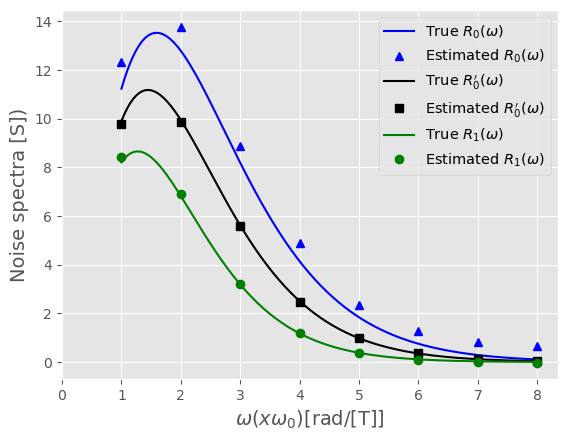

In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')


R0 =  []
R0p = []
R1 =  []
for n in range(0, varsnum*N,varsnum):
    R0.append(resultPn[n+0])
    R0p.append(resultPn[n+1])
    R1.append(resultPn[n+2])
    

omega = []
for n in range(1,N+1):
    omega.append(n*wr(1))
   
       
plt.plot( w1, spect0,'b-',omega, R0 ,'b^',\
          w1, spect1, 'k-',omega, R0p ,'ks', \
          w1, spect2, 'g-', omega, R1 ,'go') 
plt.xlabel('$\omega( x\omega_0)$[rad/[T]]', fontsize=14)
plt.xticks(np.arange(0, (N+1)*wr(1), step=T*wr(1)),np.arange(0,N+1,step=T))
plt.ylabel('Noise spectra [S])', fontsize=14)
plt.legend(['True $R_0(\omega)$',       'Estimated $R_0(\omega)$',\
            'True $R_0^\prime(\omega)$','Estimated $R_0^\prime(\omega)$',  \
            'True $R_1(\omega)$',       'Estimated $R_1(\omega)$'],  
          prop={'size': 10.5})



plt.savefig('Fig5M800.pdf')
plt.show()